## Import libaries

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
from tensorflow.keras.applications import InceptionV3
import cv2

### Load and show Image

In [2]:
image = cv2.imread('chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg', cv2.IMREAD_COLOR)
plt.imshow(image)

In [4]:
width, height = image.size
print(width, height)

712 439


In [5]:
#Lets declare our image dimensions
#we are using coloured images. 
nrows = height
ncolumns = width
channels = 3

### Load model without last layers

In [6]:
base_model=InceptionV3(weights='imagenet', include_top=False, input_shape=(nrows,ncolumns,channels))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 439, 712, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 219, 355, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 219, 355, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 219, 355, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Add last layers to Model

In [36]:
model = models.Sequential()
model.add(base_model)
# model.add(layers.Conv2D(filters=1024, kernel_size=(2,2),activation='relu'))
model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

In [37]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 12, 20, 2048)      21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 491520)            0         
_________________________________________________________________
dropout (Dropout)            (None, 491520)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               125829376 
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

In [38]:
print('Number of trainable weights before freezing the base_model:', len(model.trainable_weights))
base_model.trainable = False
print('Number of trainable weights after freezing the base_model:', len(model.trainable_weights))

Number of trainable weights before freezing the base_model: 6
Number of trainable weights after freezing the base_model: 6


In [39]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

### Create data flow from dict

In [43]:
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
#                                     width_shift_range=0.2,
#                                     height_shift_range=0.2,
#                                     shear_range=0.2,
#                                     zoom_range=0.2,
#                                     horizontal_flip=True,
#                                     fill_mode='nearest'
                                  )

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

#Create the image generators
train_generator = train_datagen.flow_from_directory(
        'chest_xray/train',
        target_size=(nrows, ncolumns),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        'chest_xray/val',
        target_size=(nrows, ncolumns),
        batch_size=batch_size,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Train model

In [44]:
#The training part
history = model.fit_generator(train_generator,
                              epochs=5,
                              validation_data=validation_generator)

Epoch 1/5
163/163 [==============================] - 1462s 9s/step - loss: 0.3302 - acc: 0.8756 - val_loss: 0.6426 - val_acc: 0.6250
Epoch 2/5
163/163 [==============================] - 1449s 9s/step - loss: 0.1619 - acc: 0.9387 - val_loss: 1.5234 - val_acc: 0.5000
Epoch 3/5
163/163 [==============================] - 1458s 9s/step - loss: 0.1436 - acc: 0.9456 - val_loss: 1.1052 - val_acc: 0.6250
Epoch 4/5
163/163 [==============================] - 1458s 9s/step - loss: 0.1244 - acc: 0.9565 - val_loss: 0.9680 - val_acc: 0.5625
Epoch 5/5
163/163 [==============================] - 1458s 9s/step - loss: 0.0972 - acc: 0.9626 - val_loss: 1.7668 - val_acc: 0.5000


### Display metrics (loss and accurcy)

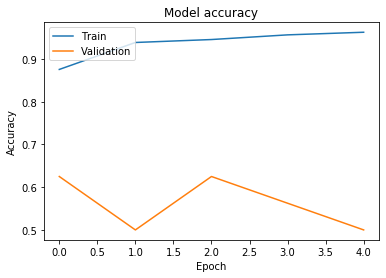

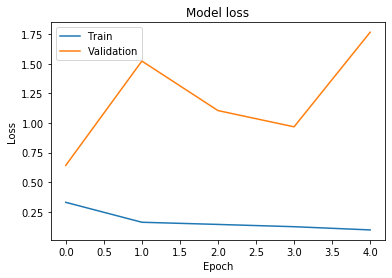

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Test results

In [80]:
test_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

#Create the image generators
test_generator = test_datagen.flow_from_directory(
        'chest_xray/test',
        target_size=(nrows, ncolumns),
        batch_size=batch_size,
        class_mode='binary')

Found 624 images belonging to 2 classes.


In [81]:
evaluate = model.evaluate_generator(test_generator, verbose=1)

20/20 [==============================] - 136s 7s/step - loss: 1.2986 - acc: 0.6538


In [76]:
predict = model.predict_on_batch(test_generator.next())

In [72]:
val_names_p = ['person1_virus_6.jpeg', 'person1_virus_7.jpeg', 'person1_virus_8.jpeg', 'person1_virus_9.jpeg']
val_names_n = ['IM-0001-0001.jpeg', 'IM-0003-0001.jpeg', 'IM-0005-0001.jpeg', 'IM-0006-0001.jpeg']
label_dict = {0:'Pneumonia', 1:'Normal'}

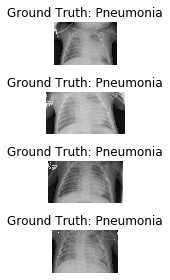

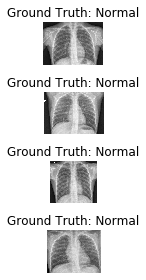

In [85]:
for i, name in enumerate(val_names_p):
    image = cv2.imread('chest_xray/test/PNEUMONIA/'+name, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    title = 'Ground Truth: ' + label_dict[0]
    plt.subplot(4, 1,i+1)
    plt.title(title)
    plt.axis('off')
    plt.imshow(image)
plt.tight_layout()
plt.show()

for i, name in enumerate(val_names_n):
    image = cv2.imread('chest_xray/test/NORMAL/'+name, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    title = 'Ground Truth: ' + label_dict[1]
    plt.subplot(4, 1,i+1)
    plt.title(title)
    plt.axis('off')
    plt.imshow(image)
plt.tight_layout()
plt.show()